In [320]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random as rd
from scipy.spatial.distance import cdist
import plotly.graph_objects as go
import vtk
import vtkplotlib as vpl
from vtk.util.numpy_support import vtk_to_numpy
from pathlib import Path

In [321]:
def readfile(filename):
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(filename)
    reader.Update()

    polydata = reader.GetOutput()

    points = polydata.GetPoints()
    array = points.GetData()
    numpy_nodes = vtk_to_numpy(array)
    #print(numpy_nodes)
    cells = polydata.GetPolys()
    nCells = cells.GetNumberOfCells()
    array = cells.GetData()
    # This holds true if all polys are of the same kind, e.g. triangles.
    assert(array.GetNumberOfValues()%nCells==0)
    nCols = array.GetNumberOfValues()//nCells
    numpy_cells = vtk_to_numpy(array)
    numpy_cells = numpy_cells.reshape((-1,nCols))
    return numpy_cells, numpy_nodes

def write_vtk(points, cell, filename):
    with open(filename, 'w') as f:
        # Write header
        f.write("# vtk DataFile Version 4.2\n")
        f.write("vtk output\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")
        
        # Write points
        num_points = len(points)
        f.write("POINTS {} float\n".format(num_points))
        for point in points:
            f.write("{} {} {}\n".format(point[0], point[1], point[2]))
        
        # Write cells
        num_cells = len(cell)
        total_num_points = np.sum(cell[:, 0])
        f.write("POLYGONS {} {}\n".format(num_cells, total_num_points + num_cells))
        for cell_indices in cell:
            num_indices = cell_indices[0]
            f.write("{} ".format(num_indices))
            for index in cell_indices[1:]:
                f.write("{} ".format(index))
            f.write("\n")

def visualize(nameOfFile):

        # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(nameOfFile)
    reader.Update()

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Create a renderer and add the actor to it
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)

    # Create a render window and set the renderer as its active renderer
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(600, 600)
    renderer.ResetCamera()

    # Create an interactor and start the visualization
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)
    interactor.Start()

def My_visualize(Faces_List=[], Wiring=[], colors=[], Scatter=[0]):
    mesh = Faces_List[0][Wiring][:, 1:]
    offset = np.zeros(mesh.shape)
    vpl.figure("Face")
    for i in range(len(Faces_List)) :
        mesh = Faces_List[i][Wiring][:, 1:] + offset
        vpl.mesh_plot(mesh, color=colors[i])
        offset[:, :, 0] += 0.01
    if Scatter[0]:
        vpl.scatter(Faces_List[0][Scatter], radius=0.0001, color='r')
    vpl.show()

def flatten(Shape):
    return np.concatenate((Shape[:, 0], Shape[:, 1], Shape[:, 2]))

def unflatten(Shape):
    n = len(Shape)//3
    return np.array([Shape[:n], Shape[n:2*n], Shape[2*n:]]).T

In [322]:
class Point3D():
    def __init__(self, array):
        self.x = array[0]
        self.y = array[1]
        self.z = array[2]
        self.coordinates = array
        return None

    def translation(self, vector):  # returns the 3D point located at current_point + vector
        coordinates = self.coordinates + vector.coordinates
        return Point3D(coordinates)

    # returns the 3D point corresponding to the homothety of the current point by a factor k
    def homothety(self, k):
        coordinates = k*self.coordinates
        return Point3D(coordinates)

    def add(self, point):
        coordinates = self.coordinates + point.coordinates
        return Point3D(coordinates)

    def Vector(self, point2):  # returns the 3D vector from current_point to point2
        coordinates = point2.coordinates - self.coordinates
        return EuclidianVector3D(coordinates)

    def toVector(self):  # returns the 3D vector associated with current_point
        return EuclidianVector3D(self.coordinates)



class EuclidianVector3D():
    def __init__(self, array):
        self.x = array[0]
        self.y = array[1]
        self.z = array[2]
        self.coordinates = array
        return None

    def translation(self, point):  # returns the 3D point located at point + current_vector
        coordinates = self.coordinates + point.coordinates
        return Point3D(coordinates)

    def add(self, vector):  # returns the vector consisting in the sum of the current and the given vectors
        coordinates = self.coordinates + vector.coordinates
        return EuclidianVector3D(coordinates)

    # returns the 3D vector corresponding to the homothety of the current vector by a factor k
    def homothety(self, k):
        coordinates = k*self.coordinates
        return EuclidianVector3D(coordinates)

    def normalize(self):
        norm = math.sqrt(self.x**2 + self.y**2 + self.z**2)
        return EuclidianVector3D(self.coordinates/norm)

    def toPoint(self):          # returns the 3D point associated with current_vector
        return Point3D(self.coordinates)

    # returns the 3D Vector representing the rotation of current_vector by an angle theta around the vector
    def rotate(self, vector, theta):
        c = math.cos(theta)
        s = math.sin(theta)

        u = vector.normalize()
        x = round((u.x**2*(1-c) + c) * self.x + (u.x*u.y*(1-c) - u.z*s) *
                  self.y + (u.x*u.z*(1-c) + u.y*s)*self.z, 10)
        y = round((u.x*u.y*(1-c) + u.z*s) * self.x + (u.y**2*(1-c) + c) *
                  self.y + (u.y*u.z*(1-c) - u.x*s)*self.z, 10)
        z = round((u.x*u.z*(1-c) - u.y*s) * self.x +
                  (u.y*u.z*(1-c) + u.x*s) * self.y + (u.z**2*(1-c) + c)*self.z, 10)
        return EuclidianVector3D(np.array(x, y, z))

In [323]:
class Sequence():
    def __init__(self, array=np.array([])):
        self.samples = array

    def map(self, f):
        return Sequence([f(sample) for sample in self.samples])

    def reduce(self, f):
        result = self.samples[0]
        for i in range(1, len(self.samples)):
            result = f(result, self.samples[i])
        return result

class Shape():
    def __init__(self, cells, nodes, neighbors={}):
        self.cells = cells
        self.nodes = nodes

    def save_shape(self, filename):
        with open(filename, 'w') as f:
            for node in self.nodes.samples:
                f.write(str(node))
            for cell in self.cells.samples:
                f.write(str(cell))
            f.write(str(self.neighbors))
    
    def map(self,f):
        return Shape(cells = self.cells, nodes= Sequence(np.array([f(node) for node in self.nodes.samples])))

In [324]:
# computes the deformation field as a sequence of vectors based on the two given shapes
def Deformation(shape1, shape2):
    vectors = []  # the shapes are sequences of points in which each id corresponds to the same point in the correspondance
    for id in range(len(shape1.nodes.samples)):
        vectors.append(shape1.nodes.samples[id].Vector(shape2.nodes.samples[id]))
    return Sequence(vectors)

In [325]:
def meanshape(seq):  # computes the mean shape of the given sequence of shapes

    def sum(shape1, shape2):
        list = []
        for i in range(len(shape1.nodes.samples)):
            list.append(shape1.nodes.samples[i].add(shape2.nodes.samples[i]))
        return Shape(cells = shape1.cells, nodes = Sequence(np.array(list)))

    n = len(seq.samples)

    ms = seq.reduce(sum).map(lambda x: x.homothety(1/n))

    return ms

In [326]:
def covariance_matrix(seq):
    
    vector_list = []
    for vector in seq.samples[0].samples:
        vector_list += list(vector.coordinates)
    tot_vector = np.array([vector_list], dtype = 'f')

    Matrix = np.matmul(np.transpose(tot_vector), tot_vector)

    for deformation_field in range(1,len(seq.samples)):
        vector_list = []
        for vector in seq.samples[deformation_field].samples:
            vector_list+= list(vector.coordinates)
        
        tot_vector = np.array([vector_list])
        Matrix += np.matmul(np.transpose(tot_vector), tot_vector)
    
    return Matrix/(len(seq.samples) - 1)

def covariance_matrix_restriction(seq1,seq2):
    vector1_list = []
    vector2_list = []
    for vector in seq1.samples[0].samples:
        vector1_list += list(vector.coordinates)
    for vector in seq2.samples[0].samples:
        vector2_list += list(vector.coordinates)
    
    vector1 = np.array([vector1_list])
    vector2 = np.array([vector2_list])
    Matrix = np.matmul(np.transpose(vector2),vector1)

    for deformation_field in range(1,len(seq1.samples)):
        vector1_list = []
        vector2_list = []
        for vector in seq1.samples[deformation_field].samples:
            vector1_list += list(vector.coordinates)
        for vector in seq2.samples[deformation_field].samples:
            vector2_list += list(vector.coordinates)
        
        vector1 = np.array([vector1_list])
        vector2 = np.array([vector2_list])
        Matrix += np.matmul(np.transpose(vector2),vector1)

    return Matrix/(len(seq1.samples)-1)

In [327]:
def norm(array):
    return math.sqrt(array[0]**2+array[1]**2+array[2]**2)


def covariance_function(x1, x2, seq):
    matrix = np.matmul(np.transpose(np.array([list(seq.samples[0].samples[x2].coordinates)])), np.array(
        [list(seq.samples[0].samples[x1].coordinates)]))

    for i in range(1, len(seq.samples)):
        matrix += np.matmul(np.transpose(np.array([list(seq.samples[i].samples[x2].coordinates)])), np.array(
            [list(seq.samples[i].samples[x1].coordinates)]))

    return matrix/len(seq.samples)

def gaussian_kernel(point1,point2,sigma_list = [1,1,1],s_list = [0.01,0.01,0.01]):
    return np.matrix([[s_list[0]*math.exp(-norm(point1.coordinates - point2.coordinates)/sigma_list[0]),0,0],[0,s_list[1]*math.exp(-norm(point1.coordinates - point2.coordinates)/sigma_list[1]),0],[0,0,s_list[2]*math.exp(-norm(point1.coordinates - point2.coordinates)/sigma_list[2])]])

In [328]:
def Gaussian_kernel_covariance_matrix(seq, Yindex, meanshape, sigma):

    Mat = np.zeros((len(Yindex), len(Yindex)))

    for i in range(len(Yindex)):
        for j in range(i, len(Yindex)):
            Mat[i,j] = math.exp(-norm(meanshape.nodes.samples[Yindex[i]].coordinates - meanshape.nodes.samples[Yindex[j]].coordinates)/sigma)
            Mat[j,i] = math.exp(-norm(meanshape.nodes.samples[Yindex[i]].coordinates - meanshape.nodes.samples[Yindex[j]].coordinates)/sigma)
    
    return Mat

def newmult(vector, matrix,s_list):
    print(len(vector))
    new_vect = np.array([0 for _ in range(len(vector))])
    for i in range(len(vector)):
        v1 = matrix[i//3]
        v2 = np.array([vector[3*j + (i%3)] for j in range(len(vector)//3)])
        print(v1.shape)
        print(v2.shape)
        new_vect[i] = s_list[i%3] * (v1 @ v2)
    
    return new_vect

In [329]:
def posterior_meanshape(seq, seq_observations, Yindex, meanshape ,utilde,s_list, sigma2_measure = 0):
    
    print("begin pms")
    observation_cov_matrix = Gaussian_kernel_covariance_matrix(seq, Yindex, meanshape, 0.01)
    print(observation_cov_matrix)
    print("obs_cov_mat done")
    constant_matrix = newmult(utilde,np.linalg.inv(observation_cov_matrix + sigma2_measure*np.eye(len(observation_cov_matrix))),s_list)
    print("constant_mat done")
    list_mean = []
    for point_id in range(len(seq.samples[0].samples)):
        KxY = covariance_matrix_restriction(Sequence(np.array([Sequence(np.array([seq.samples[i].samples[point_id]])) for i in range(len(seq.samples))])),seq_observations)
        list_mean.append(Point3D(np.array((meanshape.nodes.samples[point_id].coordinates + np.matmul(constant_matrix,KxY)))))
    print("pms done")
    return Sequence(np.array(list_mean))
    
def posterior_covariance_function(x1,x2,pms, seq, seq_observations, sigma_list, s_list, sigma2_measure = 0):

    observation_cov_matrix = covariance_matrix(seq_observations)
    constant_matrix = np.linalg.inv(observation_cov_matrix + sigma2_measure*np.eye(len(observation_cov_matrix)))
    return gaussian_kernel(pms.samples[x1],pms.samples[x2],sigma_list,s_list) - np.matmul(covariance_matrix_restriction(seq_observations,Sequence(np.array([Sequence(np.array([seq.samples[i].samples[x2]])) for i in range(len(seq.samples))]))),np.matmul(constant_matrix,covariance_matrix_restriction(Sequence(np.array([Sequence(np.array([seq.samples[i].samples[x1]])) for i in range(len(seq.samples))])),seq_observations)))


def reorganisation(meanshape, seq,  obs_dict):

    X_index = []
    Y_index = []
    utilde = []
    for i in range(len(meanshape.nodes.samples)):
        if i in obs_dict:
            Y_index.append(i)
            utilde += list(obs_dict[i])
        else:
            X_index.append(i)
    
    utilde = np.array(utilde)
    restriction_Y = Sequence(np.array([Sequence(np.array([seq.samples[i].samples[j] for j in Y_index])) for i in range(len(seq.samples))]))
    return Y_index, restriction_Y, utilde

Définition du Dataset

In [330]:
shape_list = []
dir = '../Aligned_data/'
pathlist = Path(dir).glob('*.vtk')
for filename in pathlist:
    cells, nodes = readfile(filename)
    nodes = np.array([Point3D(nodes[i]) for i in range(len(nodes))])
    shape_list.append(Shape(cells = Sequence(np.array(cells)), nodes = Sequence(np.array(nodes))))

In [331]:
new_shape_list = []

for shape in shape_list:
    new_nodes = []
    for id_node in range(len(shape.nodes.samples)//50, 17*len(shape.nodes.samples)//80):
        new_nodes.append(shape.nodes.samples[id_node])
    
    new_shape_list.append(Shape(cells = shape.cells, nodes = Sequence(np.array(new_nodes))))

shape_test = new_shape_list.pop()
shapes = Sequence(np.array(new_shape_list))

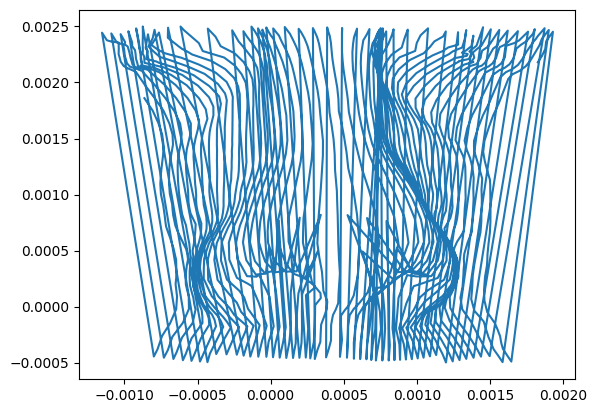

In [332]:
nodes_test = shape_test.nodes.samples
obs_dict = {}
liste_X = []
liste_Y = []
for id_node in range(len(nodes_test)):
    if id_node in range(5*len(nodes_test)//12, len(nodes_test)):
        if nodes_test[id_node].coordinates[1] >= -0.0005 and nodes_test[id_node].coordinates[1] <= 0.0025:
            liste_X.append(nodes_test[id_node].coordinates[0])
            liste_Y.append(nodes_test[id_node].coordinates[1])
        else:
            obs_dict[id_node] = np.array(nodes_test[id_node].coordinates)
    else:
        obs_dict[id_node] = np.array(nodes_test[id_node].coordinates)

plt.plot(liste_X,liste_Y)
plt.show()

In [333]:
sigma2 =0.1

sigma_list = [1,1,1]
s_list = [0.01 + sigma2,0.01 + sigma2,0.01 + sigma2]

ms = meanshape(shapes)
Seq = Sequence(np.array([Deformation(ms, shape) for shape in shapes.samples]))


Yindex, Y, utilde = reorganisation(ms,Seq, obs_dict)
pms = posterior_meanshape(Seq, Y, Yindex, ms, utilde, s_list, sigma2)

begin pms
[[1.         0.99608591 0.99215011 ... 0.64222498 0.64414096 0.64606588]
 [0.99608591 1.         0.99604837 ... 0.6410632  0.64299438 0.64493471]
 [0.99215011 0.99604837 1.         ... 0.63986953 0.64181547 0.64377078]
 ...
 [0.64222498 0.6410632  0.63986953 ... 1.         0.99508962 0.99019351]
 [0.64414096 0.64299438 0.64181547 ... 0.99508962 1.         0.99507934]
 [0.64606588 0.64493471 0.64377078 ... 0.99019351 0.99507934 1.        ]]
obs_cov_mat done
22152
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(7384,)
(73

In [ ]:
X_list = []
Y_list = []

for node in ms.samples:
    X_list.append(node.x)
    Y_list.append(node.y)

plt.plot(X_list,Y_list, label = "mean face")
plt.show()

X_list = []
Y_list = []

for node in pms.nodes.samples:
    X_list.append(node.x)
    Y_list.append(node.y)

plt.plot(X_list,Y_list, label = "reconstructed face")
plt.show()

X_list = []
Y_list = []

for node in nodes_test.samples:
    X_list.append(node.x)
    Y_list.append(node.y)

plt.plot(X_list,Y_list, label = "real face")
plt.show()

In [ ]:
array1 = np.array([point.coordinates for point in pms.samples])
array2 = np.array([point.coordinates for point in nodes_test.samples])

dist = 0

for i in range(len(array1)):
    dist += np.linalg.norm(array1[i]-array2[i])

print(dist/len(array1))

0.003028126797556932
